In [1]:
import pandas as pd

In [2]:
excel_path = "Customer_Churn_Data_Large.xlsx"
excel_file = pd.ExcelFile(excel_path)
sheet_names = excel_file.sheet_names
print("Sheet names in the Excel file:", sheet_names)

Sheet names in the Excel file: ['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']


The Excel file contains the following sheets:

1. Customer_Demographics – likely includes age, gender, marital status, etc.
2. Transaction_History – details of past purchases or spending behavior.
3. Customer_Service – interaction logs such as complaints or resolution status.
4. Online_Activity – digital engagement metrics (logins, time spent, etc.).
5. Churn_Status – the target variable indicating if the customer churned.

In [3]:
# Load each sheet into a DataFrame
df_demo = excel_file.parse("Customer_Demographics")
df_trans = excel_file.parse("Transaction_History")
df_service = excel_file.parse("Customer_Service")
df_online = excel_file.parse("Online_Activity")
df_churn = excel_file.parse("Churn_Status")

# Merge all data on "CustomerID"
df = df_demo.merge(df_trans, on="CustomerID", how="left")
df = df.merge(df_service, on="CustomerID", how="left")
df = df.merge(df_online, on="CustomerID", how="left")
df = df.merge(df_churn, on="CustomerID", how="left")

# Display basic info about the merged dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        6812 non-null   int64         
 1   Age               6812 non-null   int64         
 2   Gender            6812 non-null   object        
 3   MaritalStatus     6812 non-null   object        
 4   IncomeLevel       6812 non-null   object        
 5   TransactionID     6812 non-null   int64         
 6   TransactionDate   6812 non-null   datetime64[ns]
 7   AmountSpent       6812 non-null   float64       
 8   ProductCategory   6812 non-null   object        
 9   InteractionID     5204 non-null   float64       
 10  InteractionDate   5204 non-null   datetime64[ns]
 11  InteractionType   5204 non-null   object        
 12  ResolutionStatus  5204 non-null   object        
 13  LastLoginDate     6812 non-null   datetime64[ns]
 14  LoginFrequency    6812 n

The merged dataset has 6,812 entries and includes the following features:

- Customer Demographics: Age, Gender, MaritalStatus, IncomeLevel
- Transaction History: AmountSpent, ProductCategory
- Customer Service: InteractionType, ResolutionStatus (note: ~23% missing data here)
- Online Activity: LoginFrequency, ServiceUsage
- Target Variable: ChurnStatus (0 = No Churn, 1 = Churn)

Next steps:

- Preprocessing: Handle missing values and encode categorical features.
- Train/Test Split and Model Training
- Model Evaluation

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [6]:
# Drop irrelevant columns or ID columns
df_model = df.drop(columns = ["CustomerID", "TransactionID", "TransactionDate", 
                              "InteractionID", "InteractionDate", "LastLoginDate"])

In [7]:
# Seperate features and target
X = df_model.drop("ChurnStatus", axis=1)
y = df_model["ChurnStatus"]

In [8]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [10]:
# Preprocessing pipelines
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_pipeline, categorical_features),
        ("num", numerical_pipeline, numerical_features)
    ]
)

In [11]:
# Complete pipeline with Random Forest 

model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Fit the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'MaritalStatus',
                                                   'IncomeLevel',
                                                   'ProductCategory',
                                                   'InteractionType',
                                                   'ResolutionStatus',
                                                   'ServiceUsage']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'AmountSpent',
                                                   'LoginFrequency'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [15]:
# Predictions
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

In [16]:
# Evaluate performance
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1092
           1       0.97      0.86      0.91       271

    accuracy                           0.97      1363
   macro avg       0.97      0.93      0.95      1363
weighted avg       0.97      0.97      0.97      1363



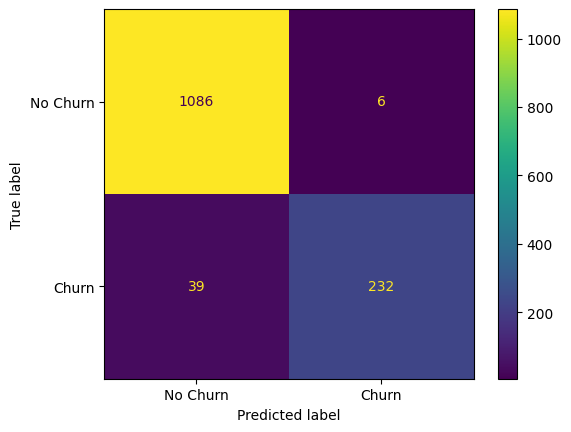

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                           display_labels=["No Churn", "Churn"]).plot()

In [30]:
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.9923


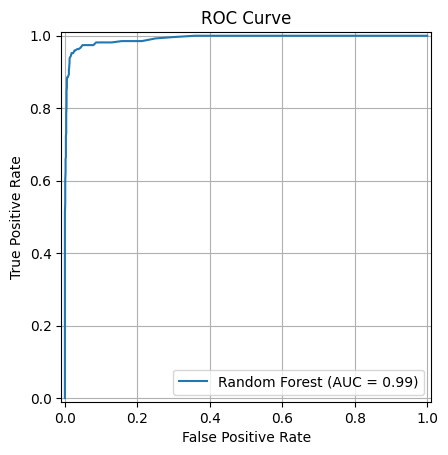

In [38]:
# Plot the ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, 
                                estimator_name="Random Forest")
roc_display.plot()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()
